Literature: 

Li, Lihong, et al. "A Contextual-Bandit Approach to Personalized News Article Recommendation.", (2010)

Zhou, Dongruo, et al. "Neural Contextual Bandits with UCB-based Exploration.", (2020)

"Deep Bayesian Bandits" by David G. K. , (2019)

Riquelme, Carlos, et al. "Deep Bayesian Bandits Showdown: An Empirical Comparison of Bayesian Deep Networks for Thompson Sampling." (2018)

Shipra Agrawal, Navin Goyal, “Thompson Sampling for Contextual Bandits with Linear Payoffs” (2012)

Tom Zahavy, Shie Mannor  “Neural Linear Bandits: Overcoming Catastrophic Forgetting through Likelihood Matching”, (2019)

Papini, Matteo, et al. “Leveraging Good Representations in Linear Contextual Bandits”

Mark Collier, Hector Urdiales Llorens “Deep Contextual Multi-armed Bandits”

Dalin Guo, et al. “Deep Bayesian Bandits: Exploring in Online Personalized Recommendations” (2020)

Bietti, Alberto, et al.“Practical Evaluation and Optimization of Contextual Bandit Algorithms” (2018)

Thanh Nguyen-Tang, et al., "Offline Neural Contextual Bandits: Pessimism, Optimization and Generalization", (2022)

Miroslav Dudik, et al. "Officient Optimal Learning for Contextual Bandits", (2011)

Alekh Agarwal, et al. "Taming the Monster: A Fast and Simple Algorithm for Contextual Bandits", (2014)

Miroslav Dudik, John Langford, Lihong Li, "Doubly Robust Policy Evaluation and Learning", (2011)

Léon Bottou, et al., "Counterfactual Reasoning and Learning Systems", (2013)

Lihong Li, Wei Chu, John Langford, Xuanhui Wang, "Unbiased Offline Evaluation of Contextual-bandit-based News Article Recommendation Algorithms", (2012)

Carlos Riquelme, George Tucker, Jasper Snoek, "Deep Bayesian Bandits Showdown: An Empirical Comparison of Bayesian Deep Networks for Thompson Sampling", (2018)

Blossom Metevier, et al., "Offline Contextual Bandits with High Probability Fairness Guarantees", (2019)

Parnian Kassraie, Andreas Krause, "Neural Contextual Bandits without Regret", (2021)

Datasets:    
Hofmann, H. (1994). Statlog (German Credit Data) [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5NC77.

github:
https://github.com/etiennekintzler/visualize_bandit_algorithms
https://github.com/david-cortes/contextualbandits

The Italian NPE Market 
https://www.pwc.com/it/it/publications/npl/doc/the-italian-NPE-market-luglio24.pdf

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from scipy.stats import gamma, norm, beta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings



In [4]:
# Ref: https://github.com/etiennekintzler/visualize_bandit_algorithms

def linUCB(alpha, X, generate_reward, true_theta):
    print("linUCB with alpha: ", alpha)
    n_trial, n_feature = X.shape
    n_arms = true_theta.shape[0]  # Infer number of arms from true_theta
    
    # 1. Initialise object
    arm_choice, r_payoff = [np.empty(n_trial) for _ in range(2)]
    theta  = np.empty(shape=(n_trial, n_arms, n_feature))
    p      = np.empty(shape=(n_trial, n_arms))
    
    # 1.2 Intermediate object
    A = np.array([np.diag(np.ones(shape=n_feature)) for _ in np.arange(n_arms)])
    b = np.array([np.zeros(shape=n_feature) for _ in np.arange(n_arms)])

    # 2. Algo
    for t in np.arange(n_trial):
        
        # Compute estimates (theta) and prediction (p) for all arms with the same context X[t]
        for a in np.arange(n_arms):
            inv_A       = np.linalg.inv(A[a])
            theta[t, a] = inv_A.dot(b[a])
            p[t, a]     = theta[t, a].dot(X[t]) + alpha * np.sqrt(X[t].dot(inv_A).dot(X[t]))
        
        # Choose best arm
        chosen_arm    = np.argmax(p[t])
        x_chosen_arm  = X[t]  # Same context for all arms
        
        # Use trial number t in the reward function
        r_payoff[t]   = generate_reward(t=t, arm=chosen_arm, x=x_chosen_arm, base_theta=true_theta)
        arm_choice[t] = chosen_arm
        
        # Update intermediate objects (A and b)
        A[chosen_arm] += np.outer(x_chosen_arm, x_chosen_arm.T)
        b[chosen_arm] += r_payoff[t] * x_chosen_arm
    
    return dict(theta=theta, p=p, arm_choice=arm_choice, r_payoff=r_payoff)

def make_theta(n_arms, n_features):
    true_theta = np.random.normal(0, 1, (n_arms, n_features))
    return true_theta


# Generate optimal arms based on true_theta
def optimal_arm(X, true_theta):
    optimal_arms = []
    for t in range(X.shape[0]):
        rewards = [generate_reward(t, arm, X[t], true_theta) for arm in range(n_arms)]
        optimal_arms.append(np.argmax(rewards))
    return np.array(optimal_arms)


# Reward function
def generate_reward(t, arm, x, base_theta, scale_noise=0.1):
    """Generate the reward in a dynamic environment."""
    oscillation = 0.2 * np.sin(t / 10) + 0.1 * np.cos(t / 15)  # Combined oscillation
    dynamic_theta = base_theta[arm] + oscillation  # Dynamic perturbation
    normal_mean = dynamic_theta.dot(x) + (0.3 if arm == 2 else 0)  # Bias for arm 1
    normal_stddev = np.maximum(0.1, np.abs(dynamic_theta.dot(x)))  # Volatility
    noise = norm.rvs(loc=normal_mean, scale=normal_stddev * scale_noise)
    return normal_mean + noise


def make_regret(payoff, oracle):
    """Calculate the cumulative regret between the payoff and the oracle."""
    payoff = np.array(payoff)
    oracle = np.array(oracle)
    return np.cumsum(oracle - payoff)


def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x["r_payoff"], oracle = oracle), label = "alpha: " + str(alpha)) \
     for (alpha, x) in results.items()]
    
def plot_estimates(x, alpha, true_theta=None, abs_ylim = None, ncol = 4):
    print("Esimates plot for alpha: ", alpha)
    if true_theta is not None:
            print("Parameter true_theta has been supplied. Plotting convergence")
    for i, arm in enumerate(np.arange(n_arms)):
        plt.subplot(int(np.ceil(n_arms / ncol)), ncol, 1 + i)
       
        if true_theta is not None:
            data_to_plot = pd.DataFrame(x[alpha]["theta"][:, arm, :]) - true_theta[arm]
        else : 
            data_to_plot = pd.DataFrame(x[alpha]["theta"][:, arm, :]) 
        plt.plot(data_to_plot)
        plt.hlines(y=0, xmin = 0, xmax = n_trial, linestyles=":")
        
        if (arm in best_arms) :
            title = "Arm: " + str(arm) + " (best)"
        else :
            title = "Arm: " + str(arm) 
        plt.title(title)
        if abs_ylim is not None :
            plt.ylim([-abs_ylim, abs_ylim])
    plt.legend(["c" + str(feature) for feature in np.arange(n_features)])   
    
def plot_selected_arms(x, bar_width = .15):
    for (i, alpha) in enumerate(x):
        xi, yi = np.unique(x[alpha]["arm_choice"], return_counts=True)
        plt.bar(xi + i * bar_width, yi, label="alpha: " + str(alpha), width=bar_width)

    plt.xticks(np.arange(n_arms) + round(len(x)/2) * bar_width, np.arange(n_arms))
    plt.legend()    
    
# Function to compute accuracy and F1 score for each alpha level
def calculate_accuracy_f1(results, optimal_arms):
    accuracy_scores = {}
    f1_scores = {}
    
    for alpha, res in results.items():
        # Extract the chosen arms
        chosen_arms = res['arm_choice']
        
        # Calculate accuracy: proportion of correctly chosen arms
        accuracy = accuracy_score(optimal_arms, chosen_arms)
        accuracy_scores[alpha] = accuracy
        
        # Calculate F1 score (binary classification, assuming two arms: 0 and 1)
        f1 = f1_score(optimal_arms, chosen_arms, average='weighted')
        f1_scores[alpha] = f1
    
    return accuracy_scores, f1_scores

In [5]:
np.random.seed(6)

# Parameters
n_trial = 1000  # Number of samples
n_features = 20    # Number of features
n_arms = 8      # Number of arms

In [6]:
# Generate synthetic context data
X = np.random.normal(0, 1, (n_trial, n_features))  # 1000 samples with 5 features

# Generate synthetic arms 
# Create the true theta (coefficients) for the arms based using bias from historic actions (simulated)

def generate_actions(n_trial, n_arms):
    return np.clip(np.random.normal(loc=n_arms/2, scale=n_arms/6, size=n_trial), 0, n_arms-1).astype(int)

historical_actions=generate_actions(n_trial, n_arms)

# Step 3: Estimate the action frequencies from historical data
action_freq = np.bincount(historical_actions, minlength=n_arms) / n_trial

print("\nAction Frequencies (from historical data):")
print(action_freq)

# Step 4: Compute bias weights (inverse of action frequency, adding small constant to avoid division by zero)
bias_weights = 1 / (action_freq + 1e-6)  # Adding small value to avoid division by zero

# Normalize bias weights so they sum to 1 (optional for controlling the magnitude of correction)
bias_weights /= np.sum(bias_weights)

print("\nBias Weights (for each action):")
print(bias_weights)

# Step 5: Apply bias correction
# Assume a small bias correction term for each action and feature
bias_correction = np.random.normal(0, 0.5, size=(n_arms, n_features))  # Small bias correction

# Scale the correction by bias weights
scaled_correction = bias_weights[:, np.newaxis] * bias_correction

# Cap large bias corrections (optional, to prevent over-correction for rare actions)
max_correction = .2  # You can tune this threshold
scaled_correction = np.clip(scaled_correction, -max_correction, max_correction)

# Step 6: Create the true theta (coefficients) for the arms
true_theta_base = make_theta(n_arms, n_features)    


# Apply the scaled bias correction to the true theta
true_theta = true_theta_base + scaled_correction
best_arms = optimal_arm(X, true_theta)    # Generate optimal arms based on true_theta



Action Frequencies (from historical data):
[0.016 0.06  0.152 0.268 0.287 0.149 0.054 0.014]

Bias Weights (for each action):
[0.3296033  0.08789824 0.03469702 0.01967897 0.01837618 0.03539562
 0.09766453 0.37668613]


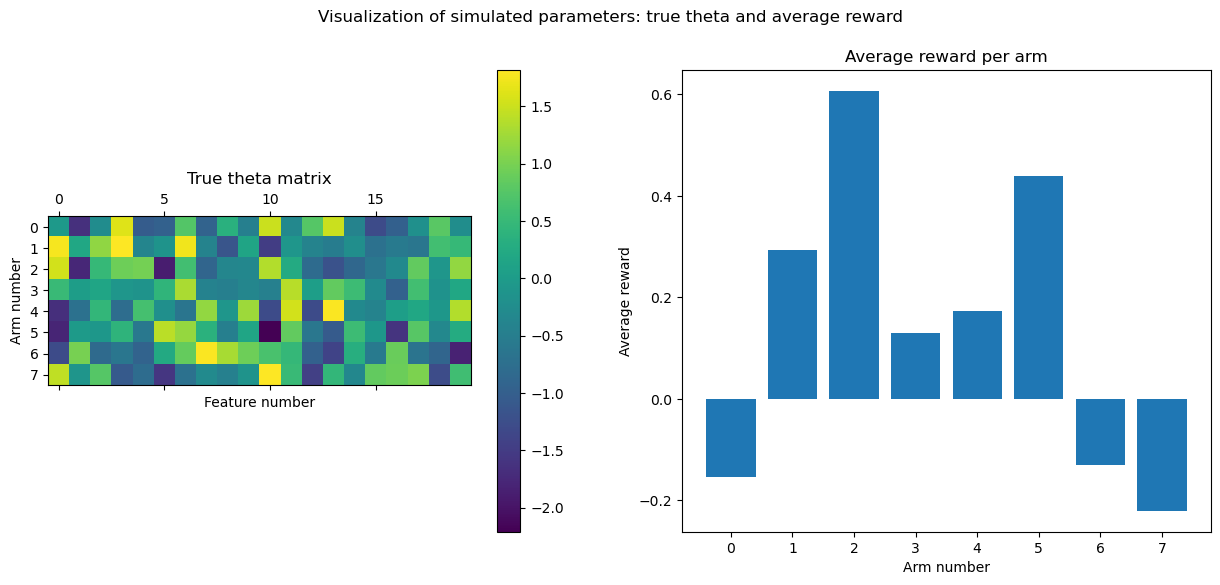

In [7]:


# Create a figure with two subplots
f, (left, right) = plt.subplots(1, 2, figsize=(15, 6))
f.suptitle("Visualization of simulated parameters: true theta and average reward", fontsize=12)

# Visualize the true theta matrix
left.matshow(true_theta)
f.colorbar(left.imshow(true_theta), ax=left)
left.set_xlabel("Feature number")
left.set_ylabel("Arm number")
left.set_yticks(np.arange(n_arms))
left.set_title("True theta matrix")

# Calculate average reward for each arm using the new generate_reward function
ave_reward = np.mean(
    [[generate_reward(t, arm=arm, x=X[t], base_theta=true_theta)  # Pass t for dynamic behavior
      for arm in np.arange(n_arms)]
     for t in np.arange(n_trial)], 
    axis=0
)


# Plot the average reward per arm
right.bar(np.arange(n_arms), ave_reward)
right.set_title("Average reward per arm")
right.set_xlabel("Arm number")
right.set_ylabel("Average reward")
plt.show()

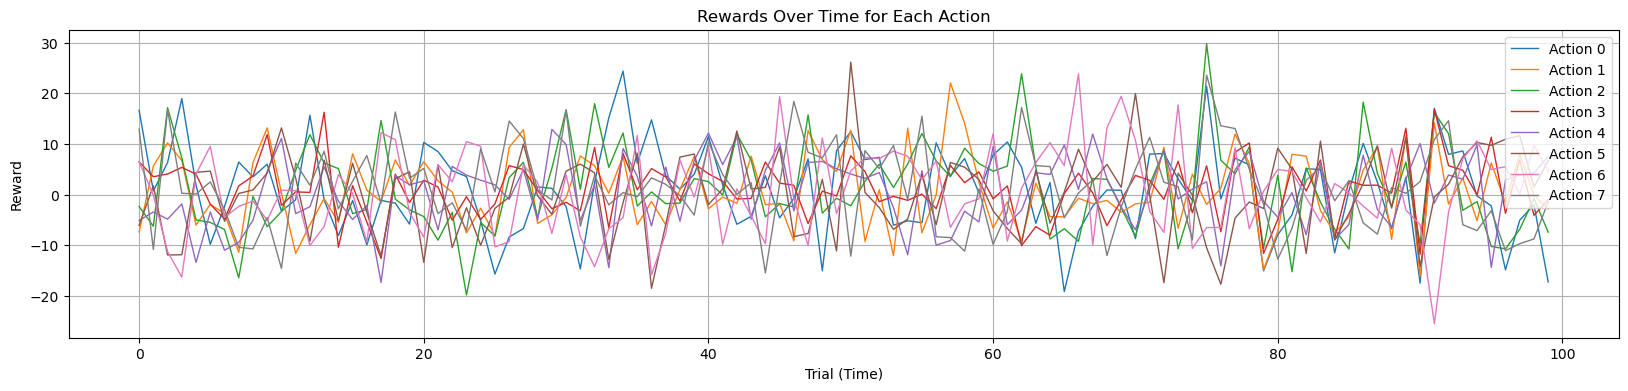

In [8]:
n_trials=100


# Store rewards for each arm over trials
rewards = np.zeros((n_trials, n_arms))

# Generate rewards for each arm over time
for t in range(n_trials):
    for arm in range(n_arms):
        rewards[t, arm] = generate_reward(t, arm, X[t], true_theta)

# Plot the rewards for each action over time
plt.figure(figsize=(20, 4))
for arm in range(n_arms):
    plt.plot(rewards[:, arm], label=f'Action {arm}', linewidth=1)

plt.title("Rewards Over Time for Each Action")
plt.xlabel("Trial (Time)")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()


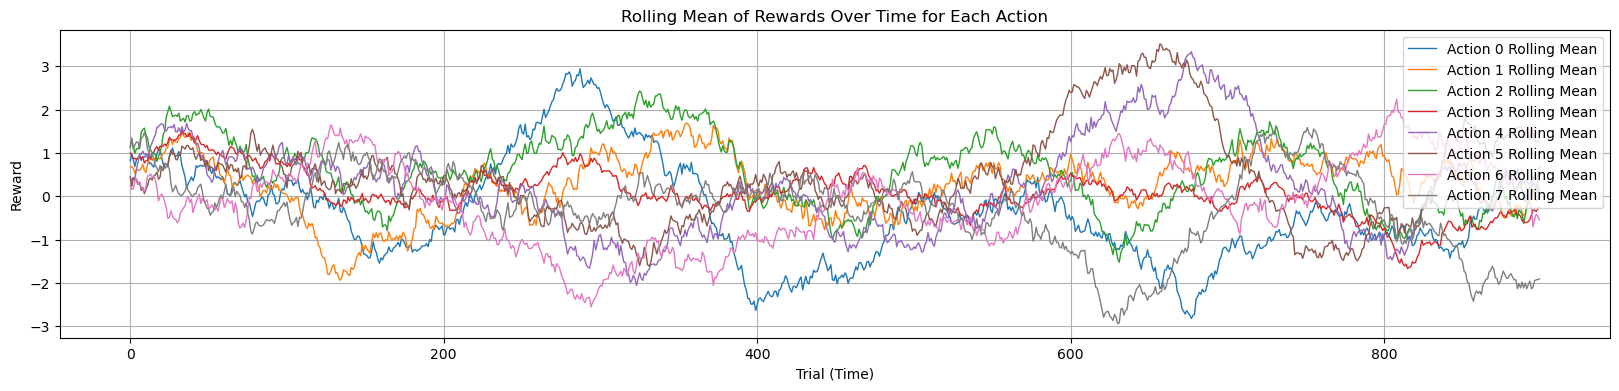

In [9]:
window_size = 100
n_trials = n_trial
# Store rewards for each arm over trials
rewards = np.zeros((n_trials, n_arms))

# Generate rewards for each arm over time
for t in range(n_trials):
    for arm in range(n_arms):
        rewards[t, arm] = generate_reward(t, arm, X[t], true_theta)

# Compute rolling mean for each arm
rolling_means = np.zeros_like(rewards)

for arm in range(n_arms):
    rolling_means[:, arm] = pd.Series(rewards[:, arm]).rolling(window=window_size, min_periods=1).mean()

# Plot the original rewards and rolling means for each action
plt.figure(figsize=(20, 4))

for arm in range(n_arms):
    plt.plot(rolling_means[window_size:, arm], label=f'Action {arm} Rolling Mean', linewidth=1)  # Rolling mean

plt.title("Rolling Mean of Rewards Over Time for Each Action")
plt.xlabel("Trial (Time)")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Calculate the oracle: maximum expected reward for each trial
oracle = np.array([
    np.max([generate_reward(t=t, arm=arm, x=X[t], base_theta=true_theta) for arm in np.arange(n_arms)])  # Pass t for dynamic behavior
    for t in np.arange(n_trial)
])

# Calculate random payoff: reward for a randomly chosen arm at each trial
payoff_random = np.array([
    generate_reward(t=t, arm=np.random.choice(n_arms), x=X[t], base_theta=true_theta)  # Pass t for dynamic behavior
    for t in np.arange(n_trial)
])

# Calculate regret for the random strategy
#regret_random = make_regret(payoff=payoff_random, oracle=oracle)



In [11]:
alpha_values = [0, 1, 2, 3, 5, 10]
results_dict = {alpha: linUCB(alpha = alpha, X=X, generate_reward=generate_reward, true_theta=true_theta)\
                for alpha in alpha_values}

linUCB with alpha:  0
linUCB with alpha:  1
linUCB with alpha:  2
linUCB with alpha:  3
linUCB with alpha:  5
linUCB with alpha:  10


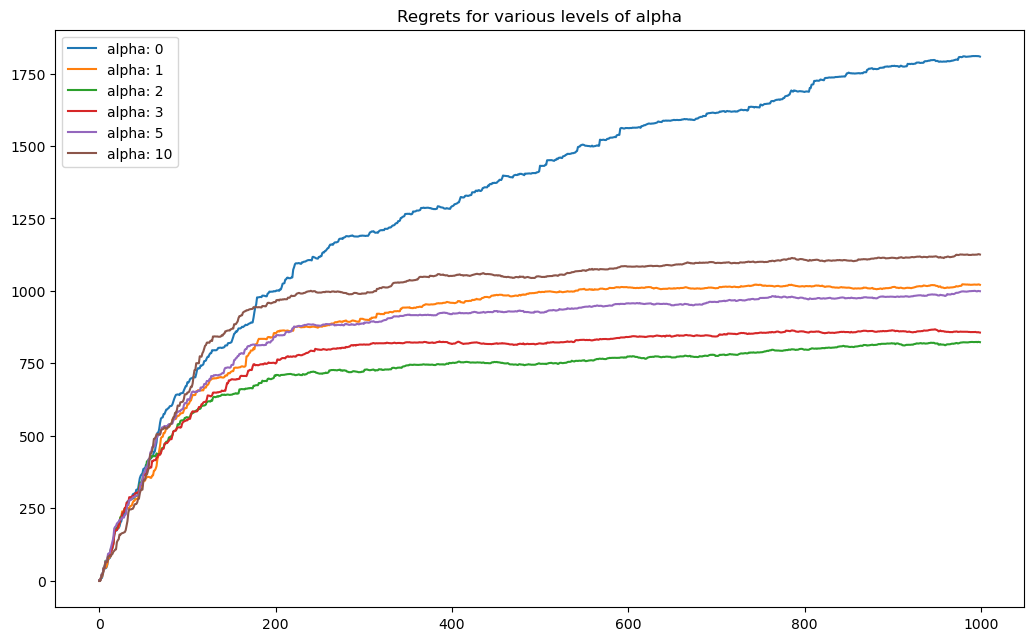

In [12]:
plt.figure(figsize = (12.5, 7.5))
plot_regrets(results_dict, oracle)
#plt.plot(make_regret(payoff=payoff_random, oracle=oracle), label="random", linestyle='--')
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()

Esimates plot for alpha:  2


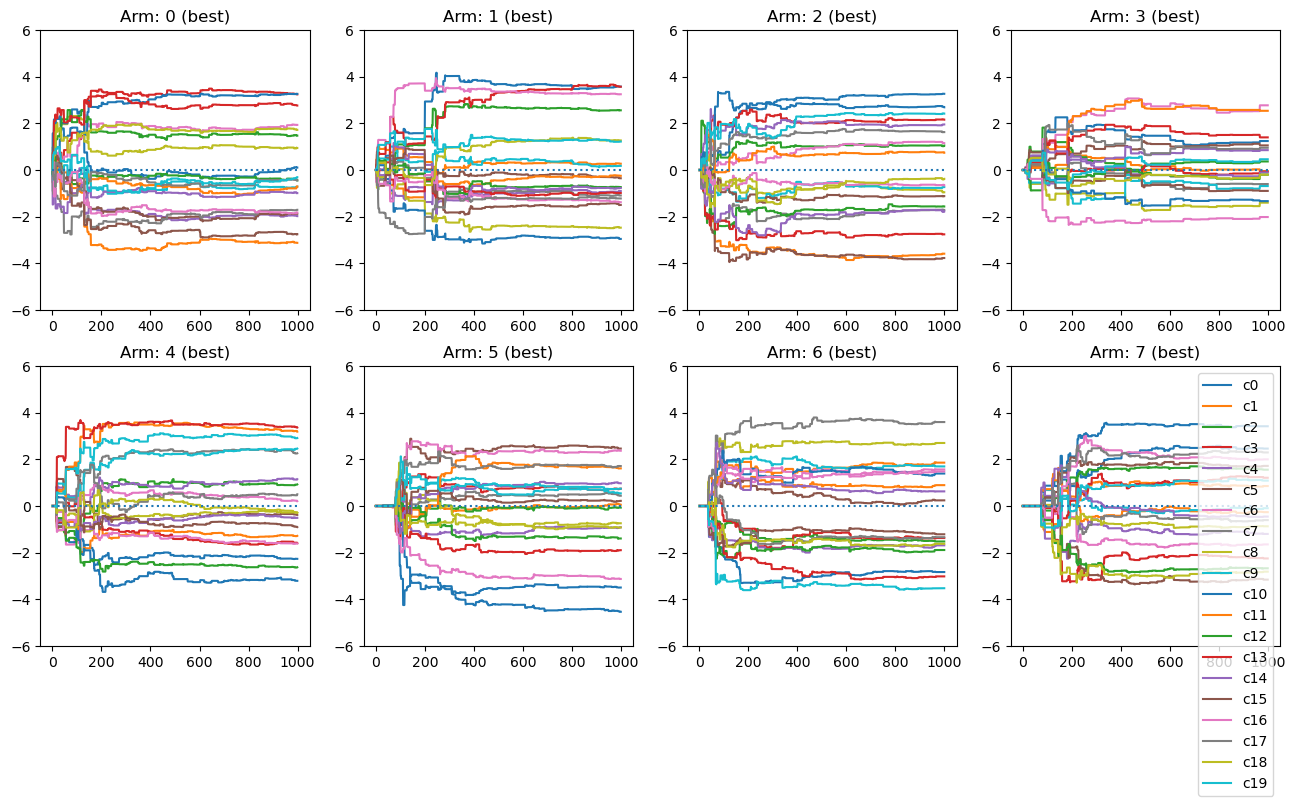

In [13]:
plt.figure(figsize = (16,8))
plot_estimates(results_dict, alpha = 2, ncol = 4, abs_ylim=6)

Esimates plot for alpha:  2
Parameter true_theta has been supplied. Plotting convergence


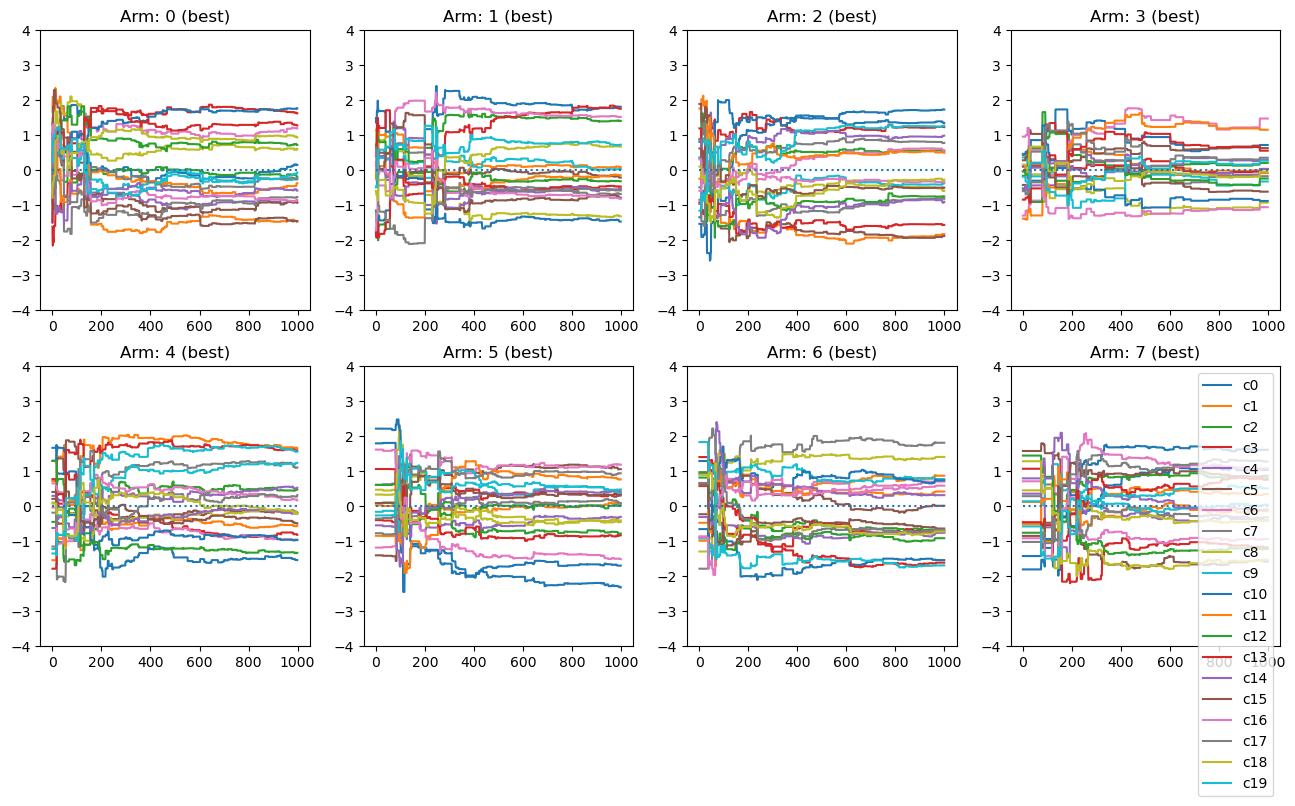

In [14]:
plt.figure(figsize = (16,8))
plot_estimates(results_dict, alpha = 2,ncol = 4, true_theta=true_theta, abs_ylim=4)

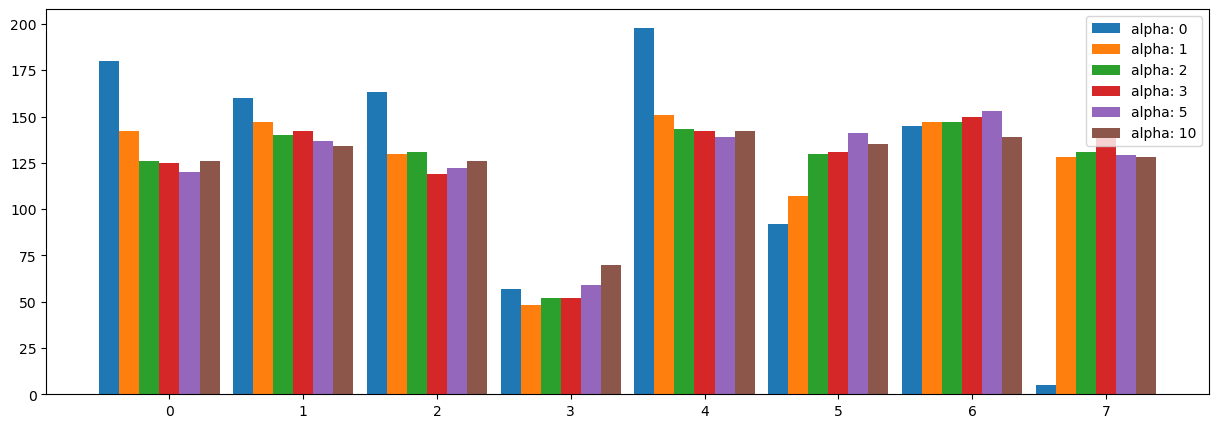

In [15]:
plt.figure(figsize = (15, 5))
plot_selected_arms(results_dict)

Accuracy Scores for different Alpha levels:
Alpha 0: Accuracy = 0.6560
Alpha 1: Accuracy = 0.7900
Alpha 2: Accuracy = 0.8170
Alpha 3: Accuracy = 0.8080
Alpha 5: Accuracy = 0.8030
Alpha 10: Accuracy = 0.7740

F1 Scores for different Alpha levels:
Alpha 0: F1 Score = 0.6053
Alpha 1: F1 Score = 0.7897
Alpha 2: F1 Score = 0.8185
Alpha 3: F1 Score = 0.8100
Alpha 5: F1 Score = 0.8059
Alpha 10: F1 Score = 0.7779


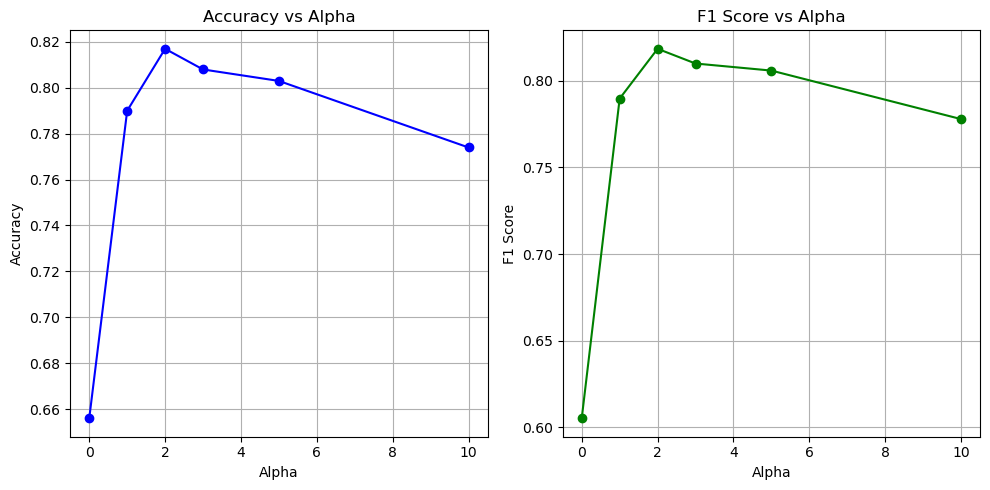

In [16]:


# Calculate accuracy and F1 score for each alpha
accuracy_scores, f1_scores = calculate_accuracy_f1(results_dict, best_arms)

# Display the results
print("Accuracy Scores for different Alpha levels:")
for alpha, score in accuracy_scores.items():
    print(f"Alpha {alpha}: Accuracy = {score:.4f}")

print("\nF1 Scores for different Alpha levels:")
for alpha, score in f1_scores.items():
    print(f"Alpha {alpha}: F1 Score = {score:.4f}")

# Plot the accuracy and F1 scores
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(alpha_values, list(accuracy_scores.values()), marker='o', label='Accuracy', color='b')
plt.title('Accuracy vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.grid(True)

# F1 score plot
plt.subplot(1, 2, 2)
plt.plot(alpha_values, list(f1_scores.values()), marker='o', label='F1 Score', color='g')
plt.title('F1 Score vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('F1 Score')
plt.grid(True)

plt.tight_layout()
plt.show()


Running linUCB with alpha: 0
Running linUCB with alpha: 1
Running linUCB with alpha: 2
Running linUCB with alpha: 3
Running linUCB with alpha: 5
Running linUCB with alpha: 10


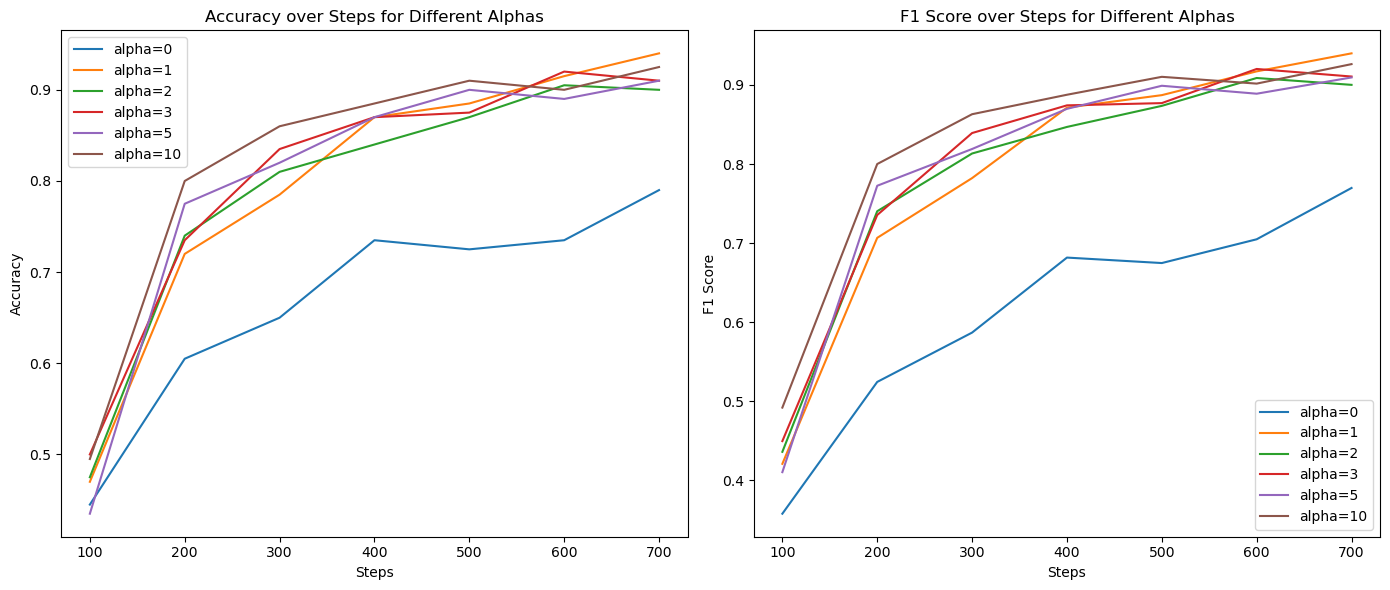

In [17]:
## Performance Tracking for multiple alpha values with train test split:

alpha_values=alpha_values


#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, best_arms, test_size=0.2, random_state=42)

# LinUCB algorithm with performance tracking
def linUCB_with_split(alpha, X, generate_reward, true_theta, X_test, y_test, eval_interval=50):
    print(f"Running linUCB with alpha: {alpha}")
    n_trial, n_feature = X.shape
    n_arms = true_theta.shape[0]  # Infer number of arms from true_theta

    # Initialize outputs
    arm_choice, r_payoff = [np.empty(n_trial) for _ in range(2)]
    theta  = np.empty(shape=(n_trial, n_arms, n_feature))
    p      = np.empty(shape=(n_trial, n_arms))
    
    # Initialize matrices A and vectors b for each arm
    A = np.array([np.eye(n_feature) for _ in range(n_arms)])
    b = np.array([np.zeros(n_feature) for _ in range(n_arms)])
    
    # Lists to store metrics over time
    accuracy_list = []
    f1_list = []
    steps = []

    # Algorithm loop
    for t in range(n_trial):
        # Compute estimates (theta) and prediction (p) for all arms with the same context X[t]
        for a in range(n_arms):
            inv_A = np.linalg.inv(A[a])
            theta[t, a] = inv_A.dot(b[a])
            p[t, a] = theta[t, a].dot(X[t]) + alpha * np.sqrt(X[t].dot(inv_A).dot(X[t]))

        # Choose the arm with the highest score
        chosen_arm = np.argmax(p[t])
        x_chosen_arm = X[t]  # Same context for all arms

        # Generate reward using the reward function
        r_payoff[t] = generate_reward(t=t, arm=chosen_arm, x=x_chosen_arm, base_theta=true_theta)
        arm_choice[t] = chosen_arm

        # Update matrices A and b for the chosen arm
        A[chosen_arm] += np.outer(x_chosen_arm, x_chosen_arm.T)
        b[chosen_arm] += r_payoff[t] * x_chosen_arm

        # Periodically evaluate performance on test set
        if t % eval_interval == 0 and t > 0:
            y_pred = np.array([np.argmax([theta[t, a].dot(x) for a in range(n_arms)]) for x in X_test])
            
            # Compute accuracy and F1 score
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            accuracy_list.append(acc)
            f1_list.append(f1)
            steps.append(t)
      #      print(f"Step {t}: Accuracy={acc}, F1 Score={f1}")

    return dict(steps=steps, accuracy=accuracy_list, f1=f1_list)

    # Plot accuracy and F1 score over time
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(steps, accuracy_list, label='Accuracy')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(steps, f1_list, label='F1 Score', color='orange')
    plt.xlabel('Steps')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return dict(theta=theta, p=p, arm_choice=arm_choice, r_payoff=r_payoff, accuracy=accuracy_list, f1=f1_list)


results_dict_split = {}

# Run the model for each alpha
for alpha in alpha_values:
    results = linUCB_with_split(alpha=alpha, X=X_train, generate_reward=generate_reward, true_theta=true_theta, 
                     X_test=X_test, y_test=y_test, eval_interval=100)
    results_dict_split[alpha] = results

# Step 9: Plot accuracy and F1 scores for different alphas
plt.figure(figsize=(14, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for alpha in alpha_values:
    plt.plot(results_dict_split[alpha]['steps'], results_dict_split[alpha]['accuracy'], label=f'alpha={alpha}')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy over Steps for Different Alphas')
plt.legend()

# Plot F1 score
plt.subplot(1, 2, 2)
for alpha in alpha_values:
    plt.plot(results_dict_split[alpha]['steps'], results_dict_split[alpha]['f1'], label=f'alpha={alpha}')
plt.xlabel('Steps')
plt.ylabel('F1 Score')
plt.title('F1 Score over Steps for Different Alphas')
plt.legend()

plt.tight_layout()
plt.show()